In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import time
from datetime import timedelta

In [2]:
#从CSV文件中获取数据
print('--------load train & test file------')
# 获取训练数据
train_dataset = pd.read_csv('MNIST_data/train.csv')
print(train_dataset.shape)
train_dataset = train_dataset.as_matrix()

#获取测试数据
test_dataset = pd.read_csv('MNIST_data/test.csv')
print(test_dataset.shape)
test_dataset = test_dataset.as_matrix()
print("------finish loading --------------------")

--------load train & test file------
(42000, 785)
(28000, 784)
------finish loading --------------------


In [3]:
#从训练数据中划分一部分作为校验数据，个人实验的时候总是报kernel error，可能是训练数据划分太多，一次性读取超载，这里我设为500
#validation_size = 2000
validation_size = 1000
#用于归一化，像素值为0～255
pixel_depth = 255.0
image_width = 28
image_height = 28

In [4]:
#打乱原有的数据集，避免多次训练过拟合
from sklearn.utils import shuffle
train_dataset = shuffle(train_dataset)
print ('finish shuffling the data')

finish shuffling the data


In [5]:
#python切片操作,[x:y,m:n],表示矩阵x~y行，m~n列区间
#获取标签数据
dataset_labels = train_dataset[: ,:1]
#获取图像像素数据
dataset_images = train_dataset[: ,1:]
print(dataset_labels.shape)
print(dataset_images.shape)

(42000, 1)
(42000, 784)


In [6]:
from sklearn.preprocessing import OneHotEncoder
# 使用ont-hot编码
enc = OneHotEncoder().fit(dataset_labels.reshape(-1, 1))
# 标签数据
dataset_labels = enc.transform(dataset_labels.reshape(-1, 1)).toarray()

print("Training set", dataset_labels.shape)
print ('labels[{0}] => {1}'.format(1,dataset_labels[1]))

('Training set', (42000, 10))
labels[1] => [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


In [7]:
del train_dataset

In [8]:
# 将训练数据划分为两部分，一部分训练，一部分校验
X_val = dataset_images[:validation_size]
y_val = dataset_labels[:validation_size]

X_train = dataset_images[validation_size:]
y_train = dataset_labels[validation_size:]

In [9]:
## 归一化图像数据
X_train = (X_train.astype(float) - 
                    pixel_depth / 2) / pixel_depth

X_val = (X_val.astype(float) - 
                    pixel_depth / 2) / pixel_depth

X_test = (test_dataset.astype(float) - 
                    pixel_depth / 2) / pixel_depth

In [10]:
del dataset_images
del dataset_labels
del test_dataset

In [11]:
#将训练、测试数据转换为矩阵
X_train = X_train.reshape(-1, image_width, image_height, 1)
X_val =  X_val.reshape(-1, image_width, image_height, 1)
X_test =  X_test.reshape(-1, image_width, image_height, 1)

print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_val.shape, y_val.shape)
print('Test set', X_test.shape)
print('length',len(X_test))

('Training set', (41000, 28, 28, 1), (41000, 10))
('Validation set', (1000, 28, 28, 1), (1000, 10))
('Test set', (28000, 28, 28, 1))
('length', 28000)


In [12]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    """ Plot nrows * ncols images from images and annotate the images
    """
    fig, axes = plt.subplots(nrows, ncols)
    
    rs = np.random.choice(images.shape[0], nrows*ncols)
    
    for i, ax in zip(rs, axes.flat): 
        
        if cls_pred is None:
            title = "T: {0}".format(np.argmax(cls_true[i]))
        
        else:
            title = "T: {0}, P: {1}".format(np.argmax(cls_true[i]), cls_pred[i])  
            
        ax.imshow(images[i,:,:,0], cmap='binary')
        
        ax.set_title(title)
        
        ax.set_xticks([])
        ax.set_yticks([])
    fig.show()

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


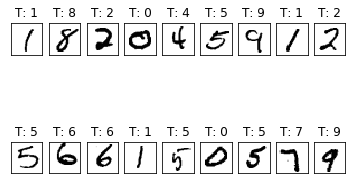

In [13]:
plot_images(X_train, 2, 9, y_train);

In [14]:
# 图像大小为28*28
img_size = X_train.shape[1] #28
# 数据集为灰度图像，只有一个通道
num_channels = X_train.shape[-1] # 1 gray
# 最终计算结果，这里对数字分类0～9，分类个数为10
num_classes = y_train.shape[1] # 10 0-9

print(img_size)
print(num_channels)
print(num_classes)

28
1
10


In [15]:
def conv_weight_variable(layer_name, shape):
    """ Retrieve an existing variable with the given layer name 
    """
    return tf.get_variable(layer_name, shape=shape, initializer=tf.contrib.layers.xavier_initializer_conv2d())

def fc_weight_variable(layer_name, shape):
    """ Retrieve an existing variable with the given layer name
    """
    return tf.get_variable(layer_name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(shape):
    """ Creates a new bias variable
    """
    return tf.Variable(tf.constant(0.0, shape=shape))

#卷积层
def conv_layer(input,               # 前一层的输出
                layer_name,         # 当前层的名字
                num_input_channels, # 前一层的神经元个数
                filter_size,        # 滤波器长度／宽度
                num_filters,        # 滤波器个数
                pooling=True):      # 是否使用2X2的池化层

    # 卷积层的权重属性
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # 创建当前层的权重
    weights = conv_weight_variable(layer_name, shape=shape)
    
    # 构造偏移量
    biases = bias_variable(shape=[num_filters])

    # 创建一个滤波器
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME') # with zero padding

    layer += biases
    
    # 使用RELU激活函数
    layer = tf.nn.relu(layer)

    # 是否使用池化层，这里使用maxpool
    if pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    return layer, weights

#降低数据维度到一维
def flatten_layer(layer):
    # 获取层结构属性
    layer_shape = layer.get_shape()

    # 计算层的features数量: img_height * img_width * num_channels
    num_features = layer_shape[1:4].num_elements()
    
    # 重新将层构造成 [图像个数, features数量].
    layer_flat = tf.reshape(layer, [-1, num_features])

    return layer_flat, num_features


#全链接层
def fc_layer(input,        # 前一层输出
             layer_name,   # 当前层的名字
             num_inputs,   # 前一层的输入个数
             num_outputs,  # 输出个数
             relu=True):   # 是否使用RELU激活函数

    # 构造滤波器和偏移量
    weights = fc_weight_variable(layer_name, shape=[num_inputs, num_outputs])
    biases = bias_variable(shape=[num_outputs])

    # 计算
    layer = tf.matmul(input, weights) + biases

    # 是否使用RELU激活函数
    if relu:
        layer = tf.nn.relu(layer)

    return layer

# 第一层卷积层
filter_size1 = 5          # 滤波器5*5
num_filters1 = 16         # 隐藏神经元个数

# 第二层卷积层
filter_size2 = 5          # 滤波器5*5
num_filters2 = 32         # 隐藏神经元个数

# 全链接层神经元个数
fc_size = 64


x = tf.placeholder(tf.float32, shape=(None, img_size, img_size, num_channels), name='x')
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')

#y_true_cls = tf.argmax(y_true, dimension=1)
y_true_cls = tf.argmax(y_true, 1)
keep_prob = tf.placeholder(tf.float32)

#计算第一个卷积层
conv_1, w_c1 = conv_layer(input=x,
                          layer_name="conv_1",
                          num_input_channels=num_channels,
                          filter_size=filter_size1,
                          num_filters=num_filters1, pooling=True)

conv_1

#计算第二个卷积层
conv_2, w_c2 = conv_layer(input=conv_1,
                          layer_name="conv_2",
                          num_input_channels=num_filters1,
                          filter_size=filter_size2,
                          num_filters=num_filters2,
                          pooling=True)

# 使用dropout层，避免过拟合
dropout = tf.nn.dropout(conv_2, keep_prob)

dropout

#降低到一维数据
layer_flat, num_features = flatten_layer(dropout)

layer_flat

#全链接层
fc_1 = fc_layer(input=layer_flat,
                layer_name="fc_1",
                num_inputs=num_features,
                num_outputs=fc_size,
                relu=True)

fc_1

fc_2 = fc_layer(input=fc_1,
                layer_name="fc_2",
                num_inputs=fc_size,
                num_outputs=num_classes,
                relu=False)

fc_2

#使用softmax
y_pred = tf.nn.softmax(fc_2)

# The class-number is the index of the largest element.
#y_pred_cls = tf.argmax(y_pred, dimension=1)
y_pred_cls = tf.argmax(y_pred, 1)

# Calcualte the cross-entropy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=fc_2, labels=y_true)

# Take the average of the cross-entropy for all the image classifications.
cost = tf.reduce_mean(cross_entropy)

# Global step is required to compute the decayed learning rate
global_step = tf.Variable(0)

# Apply exponential decay to the learning rate
learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.96, staircase=True)

# 使用AdagradOptimizer自适应学习率和BP更新权重
optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(cost, global_step=global_step)

# 计算误差
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

# 用方差表示误差
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

session = tf.Session()
session.run(tf.global_variables_initializer())

# 每一批训练样本的个数 
batch_size = 64

# dropout比例
dropout = 0.5

total_iterations = 0

#训练函数
def optimize(num_iterations, display_step):
    
    global total_iterations

    start_time = time.time()

    for step in range(num_iterations):

        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        batch_data = X_train[offset:(offset + batch_size), :, :, :]
        batch_labels = y_train[offset:(offset + batch_size), :]
        
        feed_dict_train = {x: batch_data, y_true: batch_labels, keep_prob: dropout}

        session.run(optimizer, feed_dict=feed_dict_train)
        if step % display_step == 0:
            
            batch_acc = session.run(accuracy, feed_dict=feed_dict_train)
            print("Minibatch accuracy at step %d: %.4f" % (step, batch_acc))
            
            validation_acc = session.run(accuracy, {x: X_val, y_true: y_val, keep_prob: 1.0})
            print("Validation accuracy: %.4f" % validation_acc)

    total_iterations += num_iterations

    time_diff = time.time() - start_time
    
    print("Time usage: " + str(timedelta(seconds=int(round(time_diff)))))
    


In [16]:
# increase num_iterations to get better accuracy = 5000 to 50000 &  display_step=500
optimize(num_iterations=41000, display_step=500)


Minibatch accuracy at step 0: 0.1406
Validation accuracy: 0.1510
Minibatch accuracy at step 500: 0.9844
Validation accuracy: 0.9790
Minibatch accuracy at step 1000: 0.9531
Validation accuracy: 0.9830
Minibatch accuracy at step 1500: 0.9844
Validation accuracy: 0.9860
Minibatch accuracy at step 2000: 1.0000
Validation accuracy: 0.9880
Minibatch accuracy at step 2500: 1.0000
Validation accuracy: 0.9870
Minibatch accuracy at step 3000: 0.9531
Validation accuracy: 0.9880
Minibatch accuracy at step 3500: 0.9844
Validation accuracy: 0.9890
Minibatch accuracy at step 4000: 1.0000
Validation accuracy: 0.9900
Minibatch accuracy at step 4500: 1.0000
Validation accuracy: 0.9890
Minibatch accuracy at step 5000: 1.0000
Validation accuracy: 0.9900
Minibatch accuracy at step 5500: 1.0000
Validation accuracy: 0.9930
Minibatch accuracy at step 6000: 1.0000
Validation accuracy: 0.9890
Minibatch accuracy at step 6500: 1.0000
Validation accuracy: 0.9890
Minibatch accuracy at step 7000: 1.0000
Validation a

In [17]:
##对测试数据进行计算
#test_pred = session.run(y_pred_cls, {x: X_test[:1000,:,:,:], keep_prob: 1.0})

#这里个人电脑一次跑不动这么多数据，对数据进行分割计算存储了
for step in range(0,len(X_test)/1000):
    test_pred = session.run(y_pred_cls, {x: X_test[step*1000:(step+1)*1000,:,:,:], keep_prob: 1.0})
    print(test_pred[:])
    print(len(test_pred[:]))
    print(len(test_pred[:]) * (step + 1))

    #np.savetxt('result.csv', np.c_[range(1,len(X_test)+1),test_pred], delimiter=',', header = 'ImageId,Label', comments = '', fmt='%d')
    np.savetxt('result_' + str(step) + '.csv', np.c_[range(step*1000+1,step*1000 + len(X_test[step*1000:(step+1)*1000,:,:,:])+1),test_pred], delimiter=',', header = 'ImageId,Label', comments = '', fmt='%d')


[2 0 9 9 3 7 0 3 0 3 5 7 4 0 4 3 3 1 9 0 9 1 1 5 7 4 2 7 4 7 7 5 4 2 6 2 5
 5 1 6 7 7 4 9 8 7 8 2 6 7 6 8 8 3 8 2 1 2 2 0 4 1 7 0 0 0 1 9 0 1 6 5 8 8
 2 8 9 9 2 3 5 4 1 0 9 2 4 3 6 7 2 0 6 6 1 4 3 9 7 4 0 9 2 0 7 3 0 5 0 8 0
 0 4 7 1 7 1 1 3 3 3 7 2 8 6 3 8 7 7 4 3 5 6 0 0 0 3 1 3 6 4 3 4 5 5 8 7 7
 2 8 4 3 5 6 5 3 7 5 7 8 3 0 4 5 1 2 7 6 3 0 2 7 8 6 1 3 7 4 1 2 4 8 5 2 4
 9 2 1 6 0 6 1 4 9 6 0 9 7 6 9 1 9 0 9 9 0 8 4 6 2 0 9 3 6 3 2 1 6 3 4 2 3
 1 2 2 0 4 6 1 0 0 4 9 1 7 3 2 3 8 6 8 6 2 8 5 5 4 8 3 5 9 7 1 3 8 4 5 1 4
 5 6 3 3 5 7 0 6 8 3 1 6 0 6 3 9 5 1 5 8 4 0 9 2 0 5 3 7 1 9 9 5 7 7 9 9 6
 3 0 3 3 6 9 8 2 6 3 7 1 4 5 8 5 9 0 0 3 8 4 1 8 4 1 1 9 8 4 5 1 5 3 6 3 1
 3 0 9 0 0 6 0 6 3 1 8 6 0 6 5 2 2 6 7 7 2 5 8 3 9 2 7 8 6 3 8 4 2 3 8 1 6
 4 8 7 9 7 6 9 5 3 7 6 5 5 4 2 6 2 1 3 7 1 7 9 9 6 1 1 1 7 3 9 7 6 1 1 1 9
 3 8 5 5 0 4 1 2 3 1 1 3 5 9 6 6 5 3 1 4 7 4 7 4 8 5 2 6 1 3 9 5 0 8 4 7 4
 4 4 1 5 3 9 9 7 6 9 5 9 2 3 5 6 6 7 5 0 5 1 7 4 4 1 1 4 9 5 6 0 1 3 1 0 4
 8 1 2 7 9 4 8 3 7 7 4 2 

[1 8 0 1 0 4 3 7 2 9 7 9 3 6 2 3 4 1 3 0 9 9 2 6 4 0 0 7 5 1 8 3 8 1 6 5 8
 9 3 2 0 7 1 6 7 1 6 8 4 3 5 9 1 3 5 3 1 9 2 5 8 6 3 6 0 9 2 5 1 3 7 4 4 4
 2 0 6 3 1 0 4 3 6 1 7 6 2 7 1 7 0 6 9 6 5 1 3 6 8 1 9 8 6 6 9 3 6 8 2 4 0
 6 1 8 5 1 4 0 9 9 9 4 8 4 1 6 4 9 1 8 9 2 3 4 6 1 0 1 6 7 9 0 0 8 1 4 2 5
 2 8 4 6 9 7 1 8 3 5 4 9 3 3 5 3 0 0 5 9 2 5 3 7 6 5 9 6 5 0 2 1 3 8 5 7 7
 0 7 7 1 5 6 7 0 4 3 0 0 0 0 7 6 8 8 6 7 1 3 1 0 2 3 5 1 8 6 1 7 6 3 6 6 8
 3 8 5 1 5 2 6 5 1 5 8 3 5 5 3 2 3 8 5 8 6 7 0 3 8 8 4 2 6 4 5 8 3 0 5 1 1
 3 0 9 6 7 8 2 5 3 6 2 0 6 5 1 2 9 7 0 2 5 5 6 1 4 1 3 1 5 5 0 1 9 3 9 5 0
 7 9 8 3 0 1 3 5 8 1 8 5 7 0 9 6 4 8 3 0 6 0 4 5 8 2 1 5 4 0 1 4 1 7 3 9 2
 9 1 2 1 7 6 6 1 5 9 8 9 0 2 3 1 7 6 1 5 2 7 3 2 5 9 2 4 0 5 1 5 9 1 0 9 4
 5 4 8 7 1 3 3 2 4 1 1 8 0 3 2 8 9 0 9 7 0 9 9 2 7 6 1 7 1 6 0 2 9 9 9 7 8
 2 4 0 9 3 8 9 4 2 0 3 3 0 3 9 4 8 5 5 6 9 6 8 4 7 6 7 4 9 4 2 1 0 8 1 3 6
 0 1 9 9 6 5 5 0 7 1 3 6 7 3 3 4 8 4 7 9 1 2 9 5 7 4 3 9 3 9 5 0 7 9 2 2 1
 8 3 2 7 8 7 1 2 8 7 4 8 

[0 1 5 1 6 9 8 3 4 0 3 1 0 5 3 9 8 1 7 8 5 6 8 1 1 7 1 4 8 0 8 5 6 0 7 7 1
 6 8 0 6 2 1 0 5 4 5 1 2 1 1 2 7 3 3 6 5 2 8 5 9 8 4 3 5 3 4 0 6 6 3 5 4 6
 8 1 2 7 9 0 3 4 9 6 8 6 9 3 8 2 8 4 1 1 9 3 8 1 2 3 3 9 4 7 2 4 0 1 4 3 6
 2 4 1 5 9 7 1 7 4 6 1 6 7 4 8 2 1 7 9 2 2 5 5 3 9 0 6 2 5 6 0 3 4 3 6 7 6
 0 3 5 5 8 4 0 6 9 5 6 0 1 7 5 7 5 6 4 3 4 4 6 2 2 4 7 7 3 2 0 7 4 9 2 4 2
 1 3 9 4 0 1 2 9 7 7 9 3 4 5 5 1 5 5 6 1 2 8 8 4 6 7 9 6 1 0 5 4 0 3 1 1 5
 5 3 1 2 4 6 9 2 4 1 7 9 8 5 1 1 4 3 6 2 2 1 6 7 7 1 7 3 0 1 1 5 3 1 1 3 2
 7 1 2 1 8 8 0 7 5 5 4 0 8 7 7 3 4 5 8 2 0 7 4 1 1 8 1 5 4 2 1 0 2 4 7 0 2
 8 0 2 1 9 7 3 3 4 4 1 1 4 2 3 1 0 9 8 5 9 8 6 7 3 1 6 3 7 6 1 7 3 3 5 7 7
 6 0 8 1 7 3 3 3 2 1 3 9 4 3 1 9 7 7 2 3 4 8 0 9 4 1 1 7 2 5 6 4 1 0 4 2 1
 3 7 4 0 2 8 5 8 9 4 2 5 6 8 2 9 7 0 1 7 3 3 6 9 7 5 3 1 7 0 8 1 4 1 1 1 8
 7 4 7 9 6 9 6 2 4 4 2 1 8 7 5 4 6 2 1 6 7 1 5 0 0 5 8 4 7 2 0 5 9 2 2 4 2
 4 3 0 1 8 5 1 3 2 1 3 2 4 0 4 1 8 3 7 9 5 8 8 6 4 3 7 4 9 6 8 8 6 6 5 7 8
 4 4 2 3 6 6 0 0 6 6 9 1 

[2 3 4 2 7 2 0 7 6 8 9 9 0 5 9 2 3 1 9 2 9 2 0 6 9 3 7 9 7 5 2 5 8 2 5 1 2
 1 4 7 4 8 7 4 9 4 0 3 9 0 2 6 1 0 8 5 5 2 2 2 1 3 5 9 3 3 6 7 3 6 4 3 8 6
 2 7 3 8 2 7 3 9 7 8 1 9 8 3 8 4 2 2 6 2 8 4 2 7 8 4 6 6 9 3 4 1 0 4 3 8 2
 5 0 6 1 1 9 2 7 1 5 7 3 9 9 1 3 9 7 7 2 1 8 3 8 3 9 4 2 1 4 6 7 4 6 2 6 4
 1 9 7 1 6 6 3 8 4 5 8 7 3 9 8 4 6 9 0 2 9 8 1 7 2 5 3 3 7 9 3 4 5 9 9 2 8
 8 6 1 1 8 2 2 9 6 8 8 5 1 8 1 8 0 6 0 3 4 3 3 6 9 3 2 0 8 3 0 1 9 6 0 8 5
 1 5 7 1 3 5 5 8 0 6 5 9 6 8 2 0 7 1 2 3 1 2 4 3 8 7 3 5 0 9 4 7 2 2 9 5 9
 6 8 2 2 2 1 1 2 2 8 8 5 3 9 9 0 3 1 5 3 3 0 3 8 4 5 6 0 7 7 7 6 1 5 1 2 1
 4 0 4 7 0 3 7 9 8 9 6 3 1 8 8 1 5 1 0 6 6 2 5 6 1 7 1 7 0 3 3 7 9 2 0 5 8
 0 1 1 1 7 7 3 3 2 4 6 9 6 5 5 1 3 5 6 7 2 1 7 5 7 4 6 7 8 1 6 3 1 5 5 9 9
 9 4 6 6 1 7 8 4 4 1 3 2 9 6 8 5 9 0 2 2 7 1 3 0 6 2 6 7 9 9 3 3 4 2 1 6 5
 4 0 2 4 6 2 8 6 7 3 1 4 9 5 9 4 1 5 8 1 3 5 2 7 5 2 7 1 3 4 6 8 4 4 0 4 6
 4 0 8 5 9 0 3 3 3 6 8 9 0 5 9 7 6 7 2 7 7 7 5 4 5 9 6 0 2 1 5 7 9 9 0 2 0
 0 4 3 6 0 2 3 2 9 1 9 2 

[7 0 3 4 6 3 5 2 7 7 5 5 4 9 0 3 1 5 3 1 2 0 2 4 8 9 4 2 9 2 5 9 5 3 4 2 6
 6 5 2 9 9 7 1 7 7 4 4 8 8 7 6 1 4 4 9 0 9 6 7 2 9 4 1 9 6 7 5 7 6 0 6 9 9
 9 4 2 5 5 3 0 3 6 1 8 4 6 2 7 2 7 9 9 3 4 7 1 7 6 6 1 5 0 1 3 0 1 3 2 6 5
 3 4 3 9 9 3 3 0 7 5 9 6 6 4 6 9 7 3 6 1 6 8 6 7 7 1 6 0 4 2 2 5 8 9 1 9 2
 3 3 7 9 1 5 7 1 8 8 5 6 7 6 0 7 6 3 1 0 7 9 5 7 8 1 0 9 9 4 0 0 7 7 4 4 7
 1 5 7 1 3 3 0 0 9 1 7 0 2 0 1 5 0 3 7 9 2 4 4 9 8 2 0 4 3 6 1 9 4 8 9 6 8
 9 4 9 8 5 9 2 3 8 6 5 4 5 0 1 9 0 5 8 5 1 5 4 8 2 5 9 5 1 1 8 8 0 8 4 1 9
 3 2 0 2 4 4 0 6 0 1 9 9 9 4 1 4 9 1 6 5 1 1 3 1 7 4 6 3 9 5 7 7 5 4 8 5 5
 2 4 8 8 3 1 1 3 2 9 0 4 9 4 9 0 5 3 1 4 2 0 4 1 0 7 1 9 4 8 1 4 7 8 8 1 5
 4 3 0 5 9 5 9 5 0 9 5 1 7 8 8 7 2 1 9 9 6 3 8 8 7 9 7 6 3 3 5 3 2 0 1 8 1
 1 9 1 3 0 6 2 0 0 6 9 0 1 7 3 2 6 7 7 7 7 2 2 8 1 0 9 0 2 0 7 3 7 4 5 7 5
 1 1 6 7 4 7 2 6 1 0 8 2 9 8 4 5 2 6 2 1 9 3 1 1 6 3 8 3 6 7 6 0 9 6 2 9 6
 0 5 8 0 1 0 8 7 2 9 6 4 0 2 4 1 2 0 1 4 7 6 6 9 1 7 0 7 1 1 8 8 5 2 9 1 2
 0 0 7 5 9 0 3 2 6 7 5 3 

[2 7 1 9 8 2 4 6 6 3 6 8 2 8 6 1 8 7 3 6 6 5 7 0 2 1 3 4 9 4 3 9 2 7 1 3 2
 0 3 3 9 0 4 0 6 9 5 3 7 4 5 0 1 5 0 4 2 3 4 0 1 0 5 8 4 0 3 5 8 6 9 4 4 7
 4 3 5 0 9 2 3 6 9 8 2 5 8 7 0 2 2 5 6 7 2 2 5 1 8 5 7 2 2 8 3 7 7 6 6 4 4
 1 5 8 9 0 8 8 2 3 6 2 9 8 0 2 0 5 4 8 7 4 6 6 2 9 2 2 6 2 4 0 7 6 2 1 2 6
 4 4 5 2 6 7 9 6 2 4 9 8 2 4 9 6 7 8 1 0 9 8 6 4 3 8 4 7 5 1 9 1 4 3 0 4 8
 0 9 0 0 3 2 7 1 4 2 8 4 7 8 4 3 1 0 3 2 4 2 2 7 9 4 1 4 2 3 9 8 2 9 1 6 6
 9 6 1 4 0 9 9 3 9 6 8 4 0 7 0 0 2 8 3 1 1 3 7 0 6 7 7 0 0 6 0 3 9 5 4 6 1
 7 6 3 9 8 7 8 0 4 3 8 0 1 0 7 3 0 6 2 8 2 8 4 9 6 3 4 3 9 7 1 3 2 6 2 5 5
 2 9 6 8 6 7 0 8 9 4 0 2 1 5 1 6 8 1 0 2 5 2 9 8 5 3 6 8 7 2 1 8 3 8 0 4 8
 0 9 5 0 2 6 0 2 6 3 3 6 2 8 1 7 6 8 1 2 5 5 4 0 0 1 8 2 0 7 9 9 2 0 4 7 0
 6 0 3 1 8 2 2 6 2 7 6 0 0 5 1 6 3 7 8 1 5 5 2 0 6 4 5 8 3 7 7 1 5 8 1 8 3
 3 6 8 5 0 9 8 6 2 5 1 5 0 9 8 0 9 5 8 2 0 0 5 2 2 8 3 1 3 5 8 1 0 6 8 3 1
 6 0 0 2 1 8 2 6 9 6 3 7 5 3 7 2 1 9 9 0 0 3 6 2 6 9 2 1 4 3 0 3 1 8 7 8 7
 1 3 5 1 1 4 2 3 4 9 2 0 